<a href="https://colab.research.google.com/github/shatakshisingh24/Hallo_Welt/blob/master/Trial/VGG16_cODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing libraries**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import argparse
import cv2
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset path

In [ ]:
dataset = '/content/drive/My Drive/COVID19_Dataset'

## **Setting Learning rate, epochs, and batch size**

In [ ]:
INIT_LR = 1e-3
EPOCHS = 7
BS = 15


Creating lists of data & labels

In [ ]:
imagePaths = list(paths.list_images(dataset))
data = []
labels = []

Coverting Images

In [ ]:
for imagePath in imagePaths:
	# class label from name
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# updating data to lists
	data.append(image)
	labels.append(label)


Converting into arrays

In [ ]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)


In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

*80:20 dataset split

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

Applying Data Augmentation

In [ ]:
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

Loading pre-trained network

In [ ]:
# load the ResNet15V2 network, ensuring the head FC layer sets are left
# off

#baseModel = resnet_v2.ResNet152V2(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

#baseModel = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))
#baseModel = densenet.DenseNet201(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

baseModel = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))


58892288/58889256 [==============================] - 1s 0us/step


Creating layers

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)


In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


In [ ]:
# compile our model
print("compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

compiling model...


Training

In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/7
22/22 [==============================] - 193s 9s/step - loss: 0.6257 - accuracy: 0.6760 - val_loss: 0.4898 - val_accuracy: 0.8571
Epoch 2/7
22/22 [==============================] - 192s 9s/step - loss: 0.4427 - accuracy: 0.8287 - val_loss: 0.3380 - val_accuracy: 0.9643
Epoch 3/7
22/22 [==============================] - 192s 9s/step - loss: 0.3192 - accuracy: 0.8972 - val_loss: 0.2432 - val_accuracy: 0.9405
Epoch 4/7
22/22 [==============================] - 193s 9s/step - loss: 0.2218 - accuracy: 0.9408 - val_loss: 0.1810 - val_accuracy: 0.9762
Epoch 5/7
22/22 [==============================] - 193s 9s/step - loss: 0.1826 - accuracy: 0.9626 - val_loss: 0.1544 - val_accuracy: 1.0000
Epoch 6/7
22/22 [==============================] - 192s 9s/step - loss: 0.1580 - accuracy: 0.9657 - val_loss: 0.1092 - val_accuracy: 0.9762
Epoch 7/7
22/22 [==============================] - 193s 9s/s

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


In [ ]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

      corona       1.00      1.00      1.00        41
      normal       1.00      1.00      1.00        43

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [ ]:
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))
plt.cm


[[41  0]
 [ 0 43]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


<module 'matplotlib.cm' from '/usr/local/lib/python3.6/dist-packages/matplotlib/cm.py'>

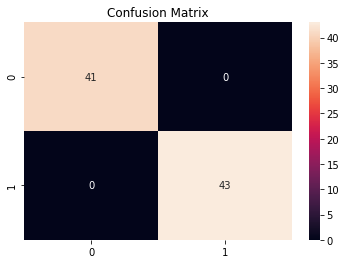

<Figure size 432x288 with 0 Axes>

In [ ]:
sn.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.show()
plt.savefig('cm_resnet50v2.png')

plot the training loss and accuracy

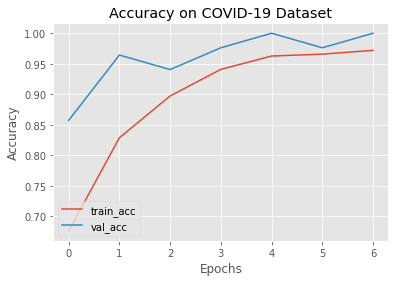

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy on COVID-19 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig('acc_resnet50v2_fc=false.png')


Plot the training loss

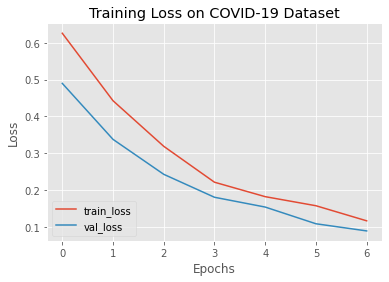

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss on COVID-19 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('loss_resnet50v2_fc=false.png')


Saving the model

In [ ]:
print("[INFO] saving COVID-19 detector model...")
model.save('covid19.h5', save_format="h5")

[INFO] saving COVID-19 detector model...


## **VALIDATION**

In [ ]:
valdata = "/content/drive/My Drive/VAL_COVID"

In [ ]:
imagePaths = list(paths.list_images(valdata))
data = []
labels = []

In [ ]:
for imagePath in imagePaths:
	# class label from name
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# updating data to lists
	data.append(image)
	labels.append(label)


In [ ]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
#print(labels)

In [ ]:
#print(testY)

In [ ]:
#print(testX)

In [ ]:
#print(data)

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(data, batch_size=BS)

[INFO] evaluating network...


In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(labels.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

      corona       0.71      1.00      0.83        32
      normal       1.00      0.67      0.80        39

    accuracy                           0.82        71
   macro avg       0.86      0.83      0.82        71
weighted avg       0.87      0.82      0.81        71



In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(labels.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [ ]:
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))
plt.cm

[[32  0]
 [13 26]]
acc: 0.8169
sensitivity: 1.0000
specificity: 0.6667


<module 'matplotlib.cm' from '/usr/local/lib/python3.6/dist-packages/matplotlib/cm.py'>

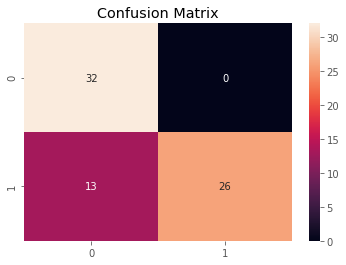

<Figure size 432x288 with 0 Axes>

In [ ]:
sn.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.show()
plt.savefig('cm_resnet50v2.png')

In [ ]:
roc_auc_score(y_true, y_scores)

NameError: ignored

In [ ]:
tpr = sensitivity
fpr = 1 - specificity
print(tpr)
print(fpr)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'y',)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()